In [6]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
In this notebook, you will build a SKLearn linear regression model to predict Yen futures ("settle") returns with *lagged* CAD/JPY exchange rate returns. 

In [7]:
# Currency pair exchange rates for CAD/JPY
cad_jpy_df = pd.read_csv(
    Path("cad_jpy.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1982-01-05,184.65,184.65,184.65,184.65
1982-01-06,185.06,185.06,185.06,185.06
1982-01-07,186.88,186.88,186.88,186.88
1982-01-08,186.58,186.58,186.58,186.58
1982-01-11,187.64,187.64,187.64,187.64


In [8]:
# Trim the dataset to begin on January 1st, 1990
cad_jpy_df = cad_jpy_df.loc["1990-01-01":, :]
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1990-01-02,126.37,126.31,126.37,126.31
1990-01-03,125.30,125.24,125.30,125.24
1990-01-04,123.46,123.41,123.46,123.41
1990-01-05,124.54,124.48,124.54,124.48
1990-01-08,124.27,124.21,124.27,124.21


# Data Preparation

### Returns

In [9]:
# Create a series using "Price" percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
# YOUR CODE HERE!
cad_jpy_df['Percentage'] = cad_jpy_df['Price'].pct_change() * 100
cad_jpy_df.dropna(inplace=True)
cad_jpy_df.head()

,Price,Open,High,Low,Percentage
Date,,,,,
1990-01-03,125.30,125.24,125.30,125.24,-0.846720
1990-01-04,123.46,123.41,123.46,123.41,-1.468476
1990-01-05,124.54,124.48,124.54,124.48,0.874777
1990-01-08,124.27,124.21,124.27,124.21,-0.216798
1990-01-09,125.10,125.04,125.10,125.04,0.667901


### Lagged Returns 

In [11]:
# Create a lagged return using the shift function
cad_jpy_df['Lagged_Return'] = cad_jpy_df['Percentage'].shift()
cad_jpy_df.dropna(inplace=True)
cad_jpy_df.head()

,Price,Open,High,Low,Percentage,Lagged_Return
Date,,,,,,
1990-01-04,123.46,123.41,123.46,123.41,-1.468476,-0.846720
1990-01-05,124.54,124.48,124.54,124.48,0.874777,-1.468476
1990-01-08,124.27,124.21,124.27,124.21,-0.216798,0.874777
1990-01-09,125.10,125.04,125.10,125.04,0.667901,-0.216798
1990-01-10,125.81,125.75,125.81,125.75,0.567546,0.667901


### Train Test Split

In [15]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train = cad_jpy_df[:'2017']
test = cad_jpy_df['2018':]

In [16]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)

X_train = train["Lagged_Return"].to_frame()
X_test = test["Lagged_Return"].to_frame()

# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
y_train = train["Percentage"]
y_test = test["Percentage"]

In [17]:
# Preview the X_train data
X_train.head()

,Lagged_Return
Date,
1990-01-04,-0.846720
1990-01-05,-1.468476
1990-01-08,0.874777
1990-01-09,-0.216798
1990-01-10,0.667901


# Linear Regression Model

In [19]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression
model = LinearRegression()

# Fit a SKLearn linear regression using  just the training set (X_train, Y_train):
model.fit(X_train, y_train)

LinearRegression()

# Make predictions using the Testing Data

**Note:** We want to evaluate the model using data that it has never seen before, in this case: `X_test`.

In [20]:
# Make a prediction of "y" values using just the test dataset
predictions = model.predict(X_test)

In [21]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
results = y_test.to_frame()
results['Predicted_Return'] = predictions

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

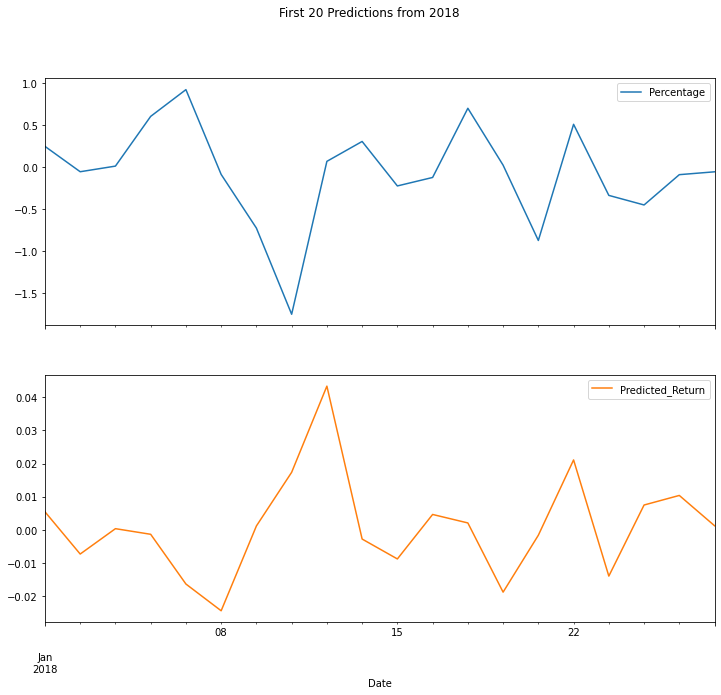

In [24]:
# Plot the first 20 predictions vs the true values
results.head(20).plot(subplots=True, 
                  figsize=(12,10),
                  title = "First 20 Predictions from 2018")


# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (`X_test` and `y_test`)

In [27]:
from sklearn.metrics import mean_squared_error
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
# (Hint: use the dataframe from above)
mse = mean_squared_error(results["Percentage"],results["Predicted_Return"])

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rmse = np.sqrt(mse)
print(f"The Out-of-Sample Root Mean Squared Error (RMSE) is: {rmse}")

The Out-of-Sample Root Mean Squared Error (RMSE) is: 0.6445805658569028


# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

In [33]:
# Construct a dataframe using just the "y" training data:
in_sample_results_df = pd.DataFrame(y_train)

# Add a column of "in-sample" predictions to that dataframe:  
in_sample_results_df["In-sample_Predictions"] = model.predict(X_train)

In [34]:
# Display the in_sample_results_df dataframe
in_sample_results_df.head()


,Percentage,In-sample_Predictions
Date,,
1990-01-04,-1.468476,0.020446
1990-01-05,0.874777,0.036249
1990-01-08,-0.216798,-0.023309
1990-01-09,0.667901,0.004436
1990-01-10,0.567546,-0.018051


In [37]:
# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
in_sample_mse = mean_squared_error(
    in_sample_results_df["Percentage"],
    in_sample_results_df["In-sample_Predictions"]
)

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
in_sample_rmse = np.sqrt(in_sample_mse)

print(f"The In-sample Root Mean Squared Error (RMSE) is: {in_sample_rmse}")


The In-sample Root Mean Squared Error (RMSE) is: 0.841994632894117


# Conclusions

**Question:** Does this model perform better or worse on out-of-sample data as compared to in-sample data?

**Answer:** 

The model performs better on the out-of-sample data as compared to in-sample data. We can see this with the smaller RMSE value for Out-of-Sample.
- The Out-of-Sample Root Mean Squared Error (RMSE) is: 0.6445805658569028
- The In-sample Root Mean Squared Error (RMSE) is: 0.841994632894117
 
In this model, the out-of-sample data is **underfitted** therefore, it does not provide a good prediciton model.

**Further Reading:**

[AWS: Documentation: Amazon Machine Learning: Developer GuideModel Fit: Underfitting vs. Overfitting](https://docs.aws.amazon.com/machine-learning/latest/dg/model-fit-underfitting-vs-overfitting.html)

```Your model is underfitting the training data when the model performs poorly on the training data. This is because the model is unable to capture the relationship between the input examples (often called X) and the target values (often called Y). Your model is overfitting your training data when you see that the model performs well on the training data but does not perform well on the evaluation data. This is because the model is memorizing the data it has seen and is unable to generalize to unseen examples.```